
=== Segment 1: Time [0, 33) ===
Bins for X: [-2.08589419 -0.8601444   0.36560539  1.59135517]
Bins for Y: [-2.07112652 -0.84869656  0.37373339  1.59616335]
P(X[t] | X[t−1]) CPT:
               X=0       X=1       X=2
X_prev=0  0.941176  0.058824  0.000000
X_prev=1  0.250000  0.500000  0.250000
X_prev=2  0.000000  0.090909  0.909091

P(Y[t] | X[t−1]) CPT:
          Y=0  Y=1  Y=2
X_prev=0  1.0  0.0  0.0
X_prev=1  0.0  1.0  0.0
X_prev=2  0.0  0.0  1.0

=== Segment 2: Time [33, 66) ===
Bins for X: [-1.9889742  -1.18775073 -0.38652727  0.4146962 ]
Bins for Y: [-0.43289241  0.36673685  1.1663661   1.96599536]
P(X[t] | X[t−1]) CPT:
               X=0       X=1       X=2
X_prev=0  0.500000  0.500000  0.000000
X_prev=1  0.266667  0.533333  0.200000
X_prev=2  0.000000  0.222222  0.777778

P(Y[t] | X[t−1]) CPT:
          Y=0  Y=1  Y=2
X_prev=0  0.0  0.0  1.0
X_prev=1  0.0  1.0  0.0
X_prev=2  1.0  0.0  0.0

=== Segment 3: Time [66, 100) ===
Bins for X: [-0.90657394 -0.05828776  0.78999842  1.6382

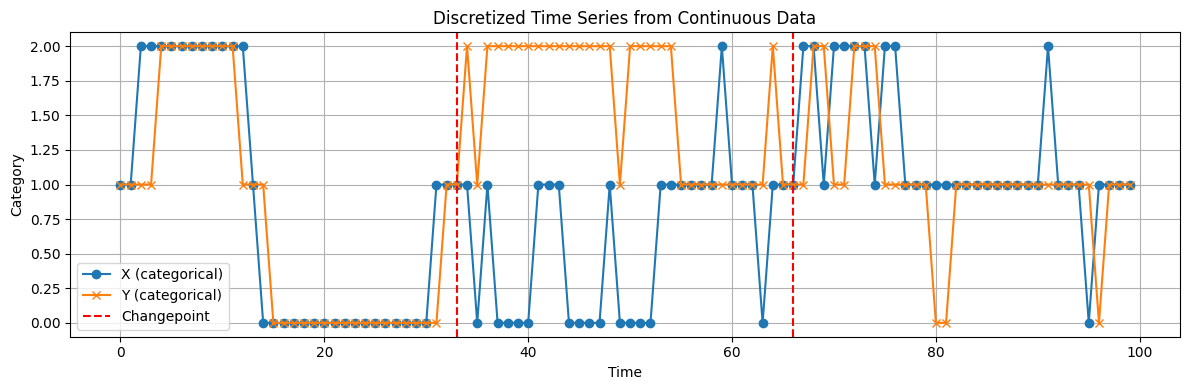

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Generate synthetic time series data with known structure
# X[t] depends on X[t−1], Y[t] depends on X[t-1] + noise
def generate_synthetic_data_2node(num_time_points=100, epsilon=0.5, snr=50):
    np.random.seed(42)
    m = num_time_points
    X = np.zeros(m)
    Y = np.zeros(m)
    phi_X = np.random.normal(0, 1, m)
    phi_Y = np.random.normal(0, 1, m)

    # Set beta with changepoints
    beta = np.ones(m)
    third = m // 3
    beta[third:(2 * third)] = -1

    # Generate X as autoregressive
    X[0] = np.random.normal(0, 1)
    for t in range(1, m):
        X[t] = np.sqrt(1 - epsilon**2) * X[t - 1] + epsilon * phi_X[t]

    # Compute noise scale for Y based on SNR
    sigma_beta_X = np.std(beta * X)
    c = sigma_beta_X / snr

    # Generate Y with a lagged dependence on X and noise
    for t in range(m - 1):
        Y[t + 1] = beta[t] * X[t] + c * phi_Y[t + 1]

    return np.vstack([X, Y]), [[third, 2 * third], [third, 2 * third]]

# Discretize continuous time series data into bins
def discretize_segment_data(segment_data, num_bins=3):
    binned_data = np.zeros_like(segment_data, dtype=int)
    bin_edges = []
    bin_probs = []

    for i in range(segment_data.shape[0]):
        bins = np.histogram_bin_edges(segment_data[i], bins=num_bins)
        binned = np.digitize(segment_data[i], bins=bins[:-1], right=False) - 1
        counts = np.bincount(binned, minlength=num_bins)
        probs = counts / counts.sum()

        binned_data[i] = binned
        bin_edges.append(bins)
        bin_probs.append(probs)

    return binned_data, bin_edges, bin_probs

# Estimate conditional probability table: P(child[t] | parent[t−1])
def estimate_cpt(parent, child, num_bins):
    cpt = np.zeros((num_bins, num_bins))
    for t in range(1, len(parent)):
        p = parent[t - 1]
        c = child[t]
        cpt[p, c] += 1

    with np.errstate(invalid='ignore'):
        cpt = cpt / cpt.sum(axis=1, keepdims=True)

    return np.nan_to_num(cpt)


# MAIN
data, changepoints = generate_synthetic_data_2node()
segments = [0] + changepoints[0] + [data.shape[1]]
num_bins = 3

for i in range(len(segments) - 1):
    start, end = segments[i], segments[i + 1]
    segment_data = data[:, start:end]

    # Discretize the segment
    binned_data, bin_edges, bin_probs = discretize_segment_data(segment_data, num_bins)

    # Estimate CPTs: P(X[t] | X[t−1]) and P(Y[t] | X[t−1])
    cpt_X = estimate_cpt(binned_data[0], binned_data[0], num_bins)
    cpt_Y = estimate_cpt(binned_data[0], binned_data[1], num_bins)

    # Print results
    print(f"\n=== Segment {i + 1}: Time [{start}, {end}) ===")
    print("Bins for X:", bin_edges[0])
    print("Bins for Y:", bin_edges[1])
    print("P(X[t] | X[t−1]) CPT:")
    print(pd.DataFrame(cpt_X, columns=["X=0", "X=1", "X=2"], index=["X_prev=0", "X_prev=1", "X_prev=2"]))

    print("\nP(Y[t] | X[t−1]) CPT:")
    print(pd.DataFrame(cpt_Y, columns=["Y=0", "Y=1", "Y=2"], index=["X_prev=0", "X_prev=1", "X_prev=2"]))


# Plot the globally discretized X and Y series with changepoints
binned_full = np.zeros_like(data, dtype=int)
for i in range(data.shape[0]):
    bins = np.histogram_bin_edges(data[i], bins=num_bins)
    binned_full[i] = np.digitize(data[i], bins=bins[:-1], right=False) - 1

plt.figure(figsize=(12, 4))
plt.plot(binned_full[0], label='X (categorical)', marker='o')
plt.plot(binned_full[1], label='Y (categorical)', marker='x')
for cp in changepoints[0]:
    plt.axvline(x=cp, color='red', linestyle='--', label='Changepoint' if cp == changepoints[0][0] else "")
plt.title('Discretized Time Series from Continuous Data')
plt.xlabel('Time')
plt.ylabel('Category')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
